<a href="https://colab.research.google.com/github/heghiw/DeepLearningPetIdentification/blob/main/baseline_exper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports

In [ ]:
## 1st -  Download utility.py file from github repository
## 2nd - Imports all functions from utility.py

import requests

# Correct raw URL for the utility.py file
url = "https://raw.githubusercontent.com/avkaz/DeepLearningPetIdentification/main/utility.py"

# Fetch and save the file locally
response = requests.get(url)
with open("utility.py", "wb") as f:
    f.write(response.content)


import utility
print("utility.py downloaded successfully.")

import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from io import BytesIO
import pandas as pd
from google.colab import files
!pip install faiss-gpu
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import faiss

data

In [2]:
data = utility.get_data()

In [18]:
trypets = list(data.items())[:20]

In [19]:
trypets

[('tanyny-chomutov-2024-12-21',
  {'Jméno': 'Tanyny',
   'Pohlaví': 'Samec',
   'Kraj': 'Ústecký',
   'Okres': 'Chomutov',
   'Plemeno': 'Kříženec',
   'Věk': '5 let',
   'Barva': 'Černá',
   'Velikost': 'Střední - 10-17kg',
   'url': 'https://www.psidetektiv.cz/zvire/tanyny-chomutov-2024-12-21',
   'images': ['https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190390.jpg',
    'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190391.jpg',
    'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190392.jpg',
    'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190393.jpg',
    'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190394.jpg']}),
 ('haily-tachov-2024-12-21',
  {'Jméno': 'Haily',
   'Pohlaví': 'Samice',
   'Kraj': 'Plzeňský',
   'Okres': 'Tachov',
   'Plemeno': 'Jezevčík',
   'Věk': '5 let',
   'Barva': 'Tmavý divočák',
   'Velikost': 'Střední - 10-17kg',
   'url': 'https://www.psidetektiv.cz/zvire/haily-tachov-2024-12-21',
   'images

model

In [36]:
model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

deleting instances with multiple pets in one posting


In [20]:
f_trypets = [
    pet for pet in trypets
    if not any(part.startswith('a') for part in pet[0].split('-')[1:])
]
f_trypets

create embeddings

In [110]:
# embeddings for FAISS
all_embeddings = []
all_pet_names = []
all_image_urls = []

for pet_id, pet_info in f_trypets:
    pet_name = pet_info['Jméno']
    for image_url in pet_info["images"]:
        embedding = utility.download_and_preprocess_image(image_url, target_size=(224, 224))
        if embedding is not None:
            all_embeddings.append(embedding.numpy().flatten())  # Flatten the embedding and add to the list
            all_pet_names.append(pet_name)
            all_image_urls.append(image_url)

all_embeddings = np.array(all_embeddings)

faiss

In [96]:
def normalize_embeddings(embeddings):
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    return embeddings / norms


# FAISS
l2_index = faiss.IndexFlatL2(all_embeddings.shape[1])  # L2

cosine_similarity_index = faiss.IndexFlatIP(all_embeddings.shape[1])  # cos

# normalized for cos similarity
normalized_embeddings = normalize_embeddings(all_embeddings)

# add to the indexes
l2_index.add(all_embeddings)

cosine_similarity_index.add(normalized_embeddings)

# test for tanyny
test_image_embedding = all_embeddings[0:1]
test_image_embedding_normalized = normalized_embeddings[0:1]

# FAISS search
l2_distances, l2_indices = l2_index.search(test_image_embedding, k=5)
cosine_sim_scores, cosine_sim_indices = cosine_similarity_index.search(test_image_embedding_normalized, k=5)

results = []

# l2 res
for idx, dist in zip(l2_indices[0], l2_distances[0]):
    results.append(("Tanyny", all_pet_names[idx], "L2 Distance", dist))


# cos sim res
for idx, score in zip(cosine_sim_indices[0], cosine_sim_scores[0]):
    results.append(("Tanyny", all_pet_names[idx], "Cosine Similarity", score))

#df
df = pd.DataFrame(
    results,
    columns=["Test Pet", "Matched Pet", "Metric", "Similarity Score"]
)

print("\nTop 5 Matches for Tanyny's First Image Using Different Metrics:\n", df)

# save as excel
#df.to_excel("top5_matches_tanyny.xlsx", index=False)
#files.download("top5_matches_tanyny.xlsx")



Top 5 Matches for Tanyny's First Image Using Different Metrics:
   Test Pet Matched Pet             Metric  Similarity Score
0   Tanyny      Tanyny        L2 Distance          0.000000
1   Tanyny      Tanyny        L2 Distance       6617.147949
2   Tanyny       Haily        L2 Distance       7191.615723
3   Tanyny      Tanyny        L2 Distance      12555.998047
4   Tanyny      Tanyny        L2 Distance      19516.195312
5   Tanyny      Tanyny  Cosine Similarity          0.999968
6   Tanyny      Tanyny  Cosine Similarity          0.841105
7   Tanyny       Haily  Cosine Similarity          0.804892
8   Tanyny      Tanyny  Cosine Similarity          0.774255
9   Tanyny      Tanyny  Cosine Similarity          0.742521


testing for more pets


In [127]:
# Normalize embeddings for cosine similarity (FAISS uses normalized vectors for Cosine similarity)
def normalize_embeddings(embeddings):
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    return embeddings / norms

# Normalize embeddings for cosine similarity
normalized_embeddings = normalize_embeddings(all_embeddings)

# Create FAISS indexes
l2_index = faiss.IndexFlatL2(all_embeddings.shape[1])  # L2 distance index
cosine_similarity_index = faiss.IndexFlatIP(all_embeddings.shape[1])  # Cosine similarity index

# Add embeddings to indexes
l2_index.add(all_embeddings)
cosine_similarity_index.add(normalized_embeddings)

# Get unique pet indices (you can adjust this part based on your dataset)
unique_pet_indices = {name: idx for idx, name in enumerate(all_pet_names)}.values()

# Define test function
def test_pet_retrieval(test_embedding_index, k=5):
    test_embedding = all_embeddings[test_embedding_index:test_embedding_index + 1]
    test_embedding_normalized = normalized_embeddings[test_embedding_index:test_embedding_index + 1]

    # Perform search using FAISS
    l2_distances, l2_indices = l2_index.search(test_embedding, k)  # L2 distance search
    cosine_sim_scores, cosine_sim_indices = cosine_similarity_index.search(test_embedding_normalized, k)  # Cosine similarity search

    results = []

    # Loop through the results and add both L2 distance and Cosine similarity
    for rank, (l2_dist, l2_idx, cos_sim_score, cos_sim_idx) in enumerate(
        zip(l2_distances[0], l2_indices[0], cosine_sim_scores[0], cosine_sim_indices[0]), start=1
    ):
        results.append({
            "Rank": rank,
            "Test_Pet": all_pet_names[test_embedding_index],
            "Matched_Pet_L2": all_pet_names[l2_idx],  # Match using L2 distance
            "Matched_Pet_Cosine": all_pet_names[cos_sim_idx],  # Match using Cosine similarity
            "L2_Distance": l2_dist,
            "Cosine_Similarity": cos_sim_score,
            "Image_URL_L2": all_image_urls[l2_idx],  # Image URL for L2 match
            "Image_URL_Cosine": all_image_urls[cos_sim_idx],  # Image URL for Cosine similarity match
        })

    return results

# Test on unique pets
for idx in unique_pet_indices:
    print(f"\nTesting retrieval for Pet: {all_pet_names[idx]}")
    results = test_pet_retrieval(idx)
    print("Results:")
    for res in results:
        print(res)



Testing retrieval for Pet: Tanyny
Results:
{'Rank': 1, 'Test_Pet': 'Tanyny', 'Matched_Pet_L2': 'Tanyny', 'Matched_Pet_Cosine': 'Tanyny', 'L2_Distance': 0.0, 'Cosine_Similarity': 0.9998541, 'Image_URL_L2': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190394.jpg', 'Image_URL_Cosine': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190394.jpg'}
{'Rank': 2, 'Test_Pet': 'Tanyny', 'Matched_Pet_L2': 'Želva', 'Matched_Pet_Cosine': 'Tanyny', 'L2_Distance': 7621.1436, 'Cosine_Similarity': 0.8709577, 'Image_URL_L2': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/19/img190186.jpg', 'Image_URL_Cosine': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190393.jpg'}
{'Rank': 3, 'Test_Pet': 'Tanyny', 'Matched_Pet_L2': 'Tanyny', 'Matched_Pet_Cosine': 'Tanyny', 'L2_Distance': 7742.9434, 'Cosine_Similarity': 0.8643462, 'Image_URL_L2': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190391.jpg', 'Image_URL_Cosine': 'https://www.psidetektiv.cz/data/catalo

In [125]:
# Function to check if the match is true for a specific metric (L2 or Cosine Similarity)
def is_true_match_for_metric(matches, metric):
    """
    Check if there are at least 2 matches where the pet matches with the test pet
    for the given metric (either L2 or Cosine).
    """
    match_count = 0
    for match in matches:
        if match == all_pet_names[metric]:  # Check if the matched pet is the correct one
            match_count += 1
    return match_count >= 2

# Define function to compare the results for each pet with separate checks for L2 and Cosine Similarity
def compare_metrics_separately(test_pet_idx, k=5):
    # Get the test results for the pet
    results = test_pet_retrieval(test_pet_idx, k)

    # Extract L2 and Cosine matches
    l2_matches = [result['Matched_Pet_L2'] for result in results]
    cos_matches = [result['Matched_Pet_Cosine'] for result in results]

    # Check true matches for L2 and Cosine separately
    l2_true_match = is_true_match_for_metric(l2_matches, test_pet_idx)
    cos_true_match = is_true_match_for_metric(cos_matches, test_pet_idx)

    return {
        'Test_Pet': all_pet_names[test_pet_idx],
        'L2_Matches': l2_matches,
        'Cosine_Matches': cos_matches,
        'L2_True_Match': l2_true_match,
        'Cosine_True_Match': cos_true_match
    }

# Compare the metrics separately for each test pet
comparison_results = []
for idx in unique_pet_indices:
    comparison_results.append(compare_metrics_separately(idx))

# Display the comparison results
for res in comparison_results:
    print(f"Testing retrieval for Pet: {res['Test_Pet']}")
    print(f"L2 Matches: {res['L2_Matches']}")
    print(f"Cosine Matches: {res['Cosine_Matches']}")
    print(f"L2 True Match: {'Yes' if res['L2_True_Match'] else 'No'}")
    print(f"Cosine True Match: {'Yes' if res['Cosine_True_Match'] else 'No'}")
    print("-" * 40)


Testing retrieval for Pet: Tanyny
L2 Matches: ['Tanyny', 'Želva', 'Tanyny', 'Tanyny', 'Endy']
Cosine Matches: ['Tanyny', 'Tanyny', 'Tanyny', 'Terina', 'Lily']
L2 True Match: Yes
Cosine True Match: Yes
----------------------------------------
Testing retrieval for Pet: Haily
L2 Matches: ['Haily', 'Haily', 'Ira', 'Alfík', 'Ira']
Cosine Matches: ['Haily', 'Alfík', 'Lily', 'Urri', 'Adolf']
L2 True Match: Yes
Cosine True Match: No
----------------------------------------
Testing retrieval for Pet: Egy
L2 Matches: ['Egy', 'Pedro', 'Haily', 'Adolf', 'Egy']
Cosine Matches: ['Egy', 'Pedro', 'Urri', 'Adolf', 'Adolf']
L2 True Match: Yes
Cosine True Match: No
----------------------------------------
Testing retrieval for Pet: Randy
L2 Matches: ['Randy', 'Terina', 'Egy', 'Randy', 'Terina']
Cosine Matches: ['Randy', 'Lily', 'Adolf', 'Lily', 'Terina']
L2 True Match: Yes
Cosine True Match: No
----------------------------------------
Testing retrieval for Pet: Alfík
L2 Matches: ['Alfík', 'Ira', 'Tanyny

Data Table of True Matches:
   Test_Pet  L2_True_Match  Cosine_True_Match
0    Tanyny           True               True
1     Haily           True              False
2       Egy           True              False
3     Randy           True              False
4     Alfík          False               True
5     Juicy          False              False
6      Urri           True               True
7      Lily           True              False
8    Užovka          False              False
9      Endy           True               True
10     Gigy          False              False
11      Rey          False              False
12    Želva          False              False
13   Terina           True               True
14    Pedro           True              False
15      Ira           True              False
16    Adolf          False              False


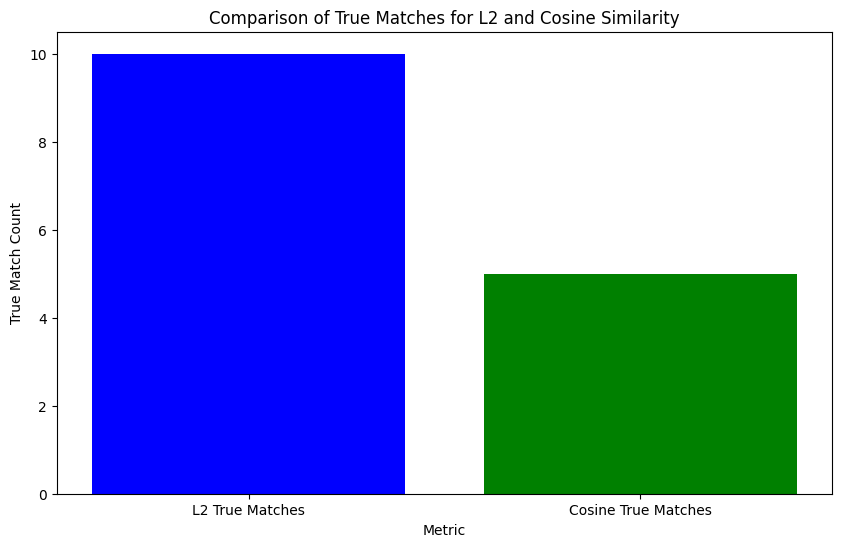

In [131]:

# Function to check if the match is true for a specific metric (L2 or Cosine Similarity)
def is_true_match_for_metric(matches, test_pet_name):
    """
    Check if there are at least 2 matches where the pet matches with the test pet
    for the given metric (either L2 or Cosine).
    """
    match_count = 0
    for match in matches:
        if match == test_pet_name:  # Check if the matched pet is the correct one
            match_count += 1
    return match_count >= 2

# Define function to compare the results for each pet with separate checks for L2 and Cosine Similarity
def compare_metrics_separately(test_pet_idx, k=5):
    # Get the test results for the pet
    results = test_pet_retrieval(test_pet_idx, k)

    # Extract L2 and Cosine matches
    l2_matches = [result['Matched_Pet_L2'] for result in results]
    cos_matches = [result['Matched_Pet_Cosine'] for result in results]

    # Get the test pet name
    test_pet_name = all_pet_names[test_pet_idx]

    # Check true matches for L2 and Cosine separately
    l2_true_match = is_true_match_for_metric(l2_matches, test_pet_name)
    cos_true_match = is_true_match_for_metric(cos_matches, test_pet_name)

    return {
        'Test_Pet': test_pet_name,
        'L2_Matches': l2_matches,
        'Cosine_Matches': cos_matches,
        'L2_True_Match': l2_true_match,
        'Cosine_True_Match': cos_true_match
    }

# Compare the metrics separately for each test pet
comparison_results = []
for idx in unique_pet_indices:
    comparison_results.append(compare_metrics_separately(idx))

# Function to create a DataFrame for results
def create_results_dataframe(comparison_results):
    # Create a list of dictionaries for the DataFrame
    data = []
    for res in comparison_results:
        data.append({
            'Test_Pet': res['Test_Pet'],
            'L2_True_Match': res['L2_True_Match'],
            'Cosine_True_Match': res['Cosine_True_Match']
        })

    # Create the DataFrame
    df = pd.DataFrame(data)

    return df

# Create a DataFrame from comparison results
comparison_df = create_results_dataframe(comparison_results)

# Display the DataFrame (data table)
print("Data Table of True Matches:")
print(comparison_df)

# Plotting the histogram to compare L2 and Cosine True Matches
plt.figure(figsize=(10, 6))

# Count the True Matches for both L2 and Cosine
l2_true_match_count = comparison_df['L2_True_Match'].sum()
cosine_true_match_count = comparison_df['Cosine_True_Match'].sum()

# Create the histogram
plt.bar(['L2 True Matches', 'Cosine True Matches'], [l2_true_match_count, cosine_true_match_count], color=['blue', 'green'])

# Add labels and title
plt.xlabel('Metric')
plt.ylabel('True Match Count')
plt.title('Comparison of True Matches for L2 and Cosine Similarity')

# Display the plot
plt.show()
